# In this notebook I'll explore further the nutritional grade and score of the dataset.


## 2.1 Understanding the nutrition score with a complete eda 
- what are the different components of the score?
- how is it calculated
- how the ingredients and additives are included in the score

## 2.2 Classification to predict the nutritional grade

## 2.3 Regression to predict the nutritional score

## 2.4 Clustering of the data and see if it correspond to the grades

-----------------------------------------------
<br>

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

-----------------------------------------------
<br>

### 2.1 Understanding the nutrition score - EDA

In [2]:
df = pd.read_csv('FoodFactCleaned.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186073 entries, 0 to 186072
Data columns (total 22 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   created_datetime                         186073 non-null  object 
 1   product_name                             186073 non-null  object 
 2   brands_tags                              186073 non-null  object 
 3   countries_en                             186073 non-null  object 
 4   ingredients_text                         186073 non-null  object 
 5   additives_n                              186073 non-null  int64  
 6   additives                                186073 non-null  object 
 7   ingredients_from_palm_oil_n              186073 non-null  int64  
 8   ingredients_that_may_be_from_palm_oil_n  186073 non-null  int64  
 9   nutrition_grade_fr                       186073 non-null  object 
 10  energy_100g                     

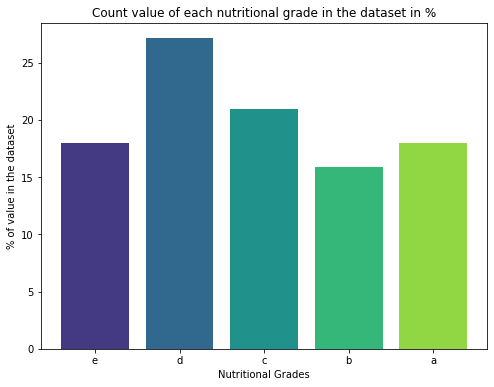

In [4]:
# count of aliments with nutri score

#count_ = df.loc[:, 'nutrition_grade_fr'].groupby('nutrition_grade_fr').agg('count')
count_vals = df.nutrition_grade_fr.value_counts()
count_vals = count_vals.reindex(index = ['e','d','c','b','a'])

palette = sns.color_palette('viridis', 5)

plt.figure(figsize=(8, 6))
plt.bar(count_vals.index,  (count_vals/df.shape[0] * 100), color=palette)
plt.xlabel('Nutritional Grades')
plt.ylabel('% of value in the dataset')
plt.title('Count value of each nutritional grade in the dataset in %')
plt.show()

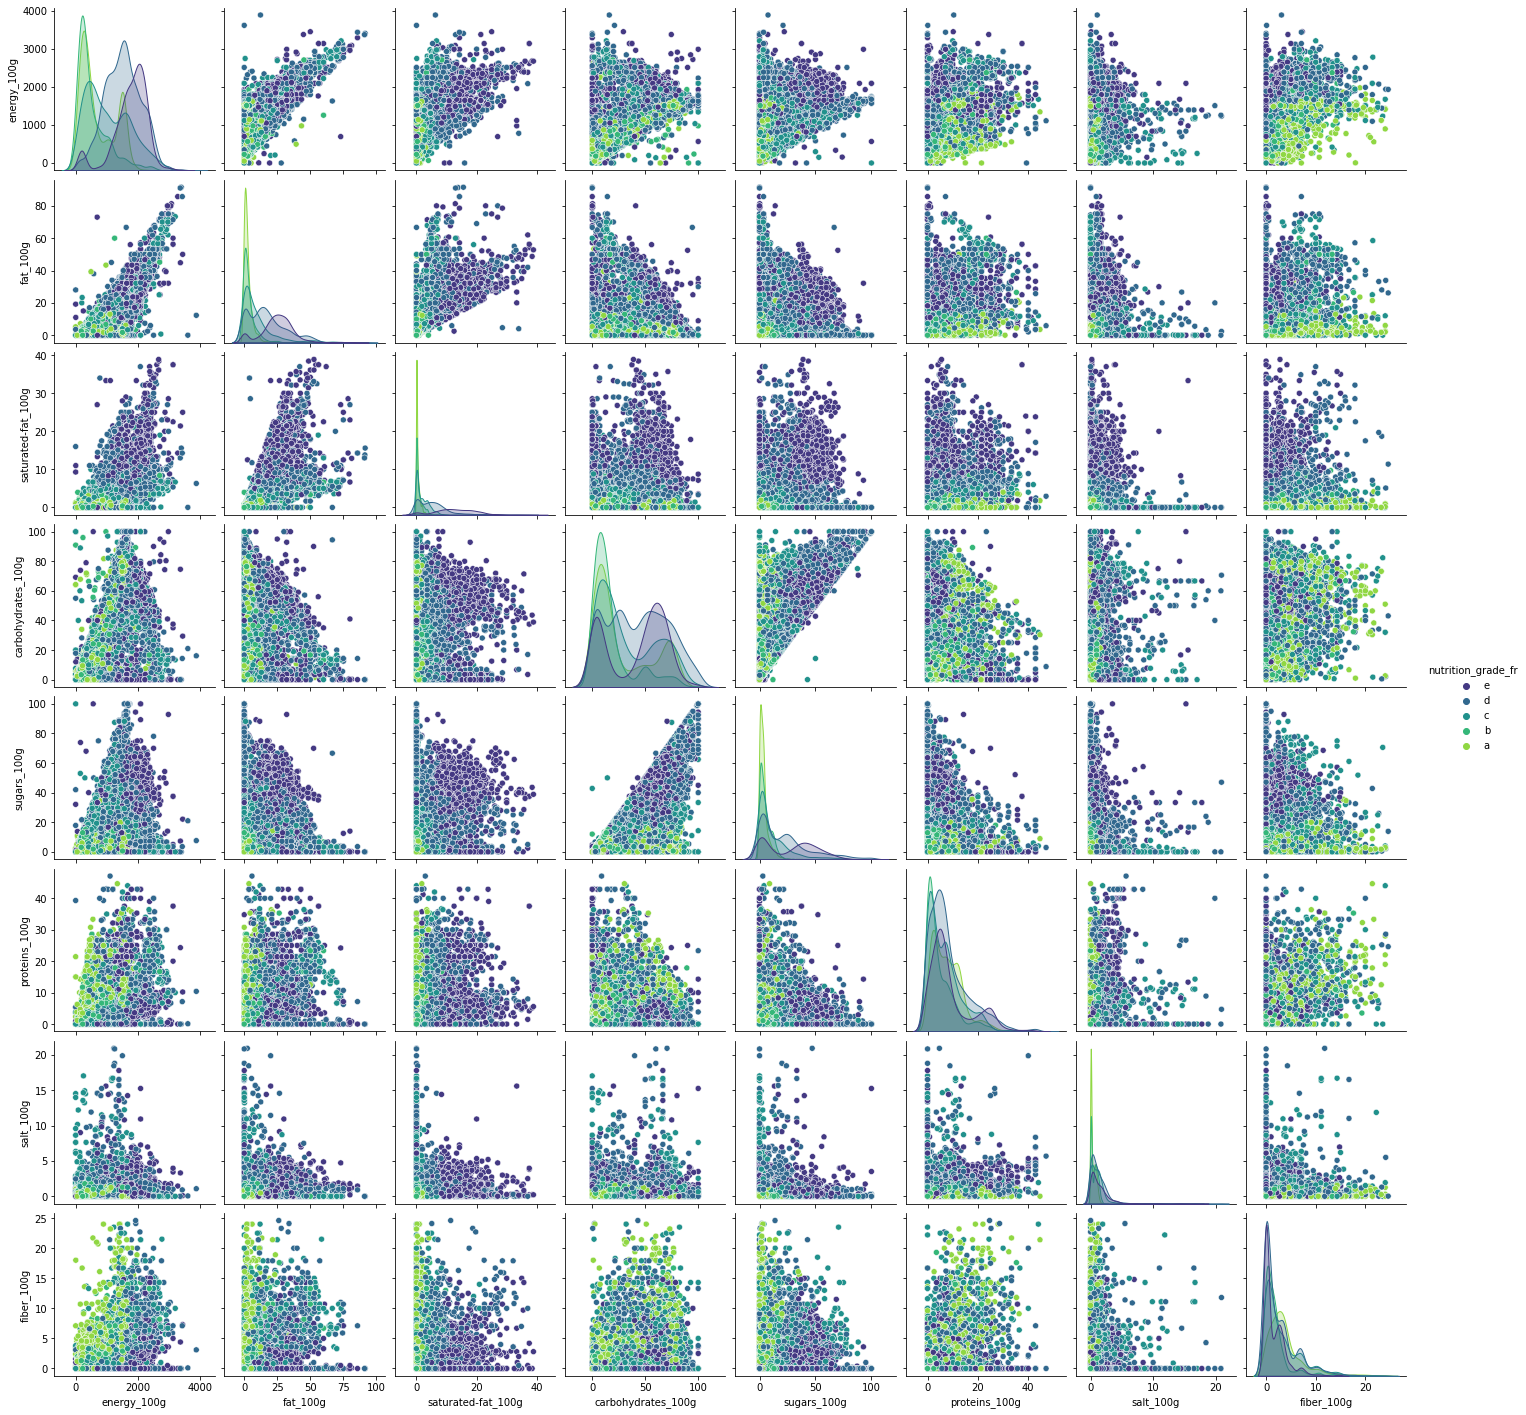

In [5]:
df_plot = df.sample(10_000)

sns.pairplot(df_plot.loc[:, ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'nutrition_grade_fr', 'fiber_100g']],
             hue='nutrition_grade_fr', 
             hue_order=['e','d','c','b','a'], 
             palette=palette);

#### Observations:

We can observe some variables particularly correlated with each other. Some correlations are obvious like fat and saturated fat.  Others show us elements that are close to each other (energy and fat or carbohydrate and sugars). 
Thanks to Seaborn's 'hue' visual, we can also easily see that the grades are not especially dependent on certain variables (all grades seem to have a more or less equal distribution in proteins for example) but are more grouped in the fiber variables where we see a lot of fiber and very little sugar, which seems indeed relevant.

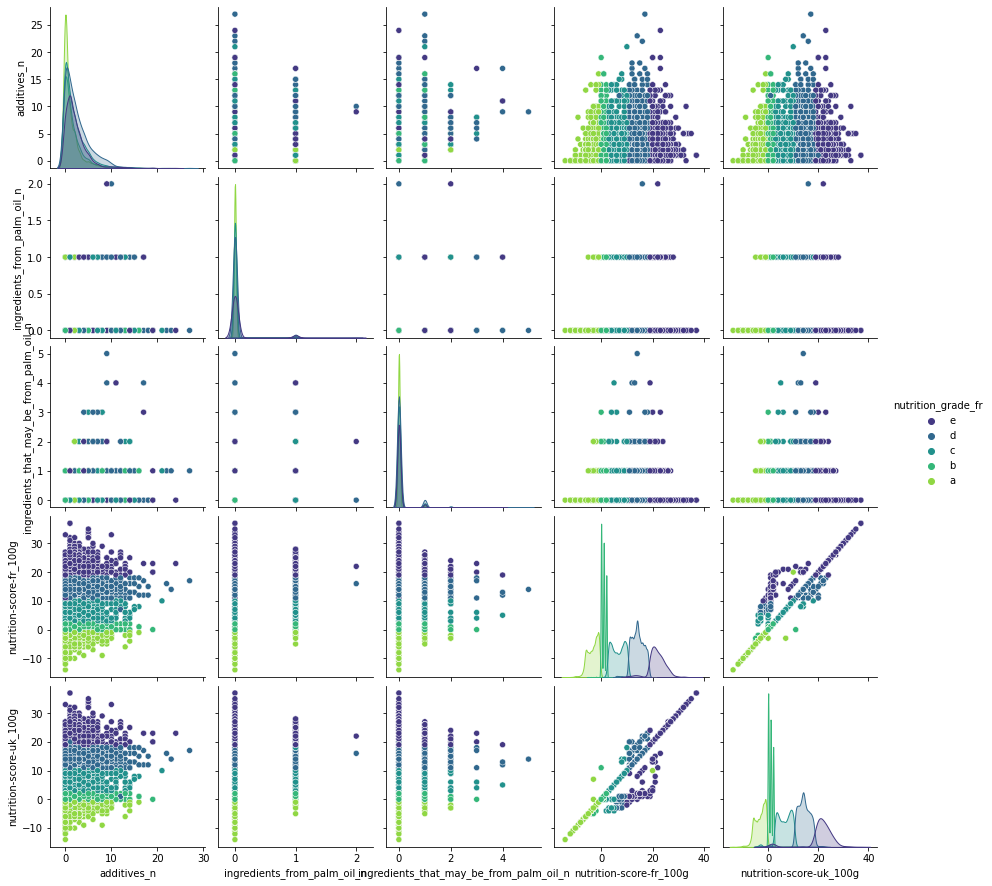

In [6]:
sns.pairplot(df_plot.loc[:, ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g','nutrition_grade_fr']],
             hue='nutrition_grade_fr', 
             hue_order=['e','d','c','b','a'], 
             palette=palette);

#### Observations:

Surprisingly, the elements of group a (the healthiest) seem to contain more additives, I will look into this result which seems contrary to me later!
As for the other variables, there doesn't seem to be a big difference, I was expecting maybe a difference in the 'ingredients from palm oil' because of the bad publicity made to it but there seems to be an equivalent distribution!

<br>


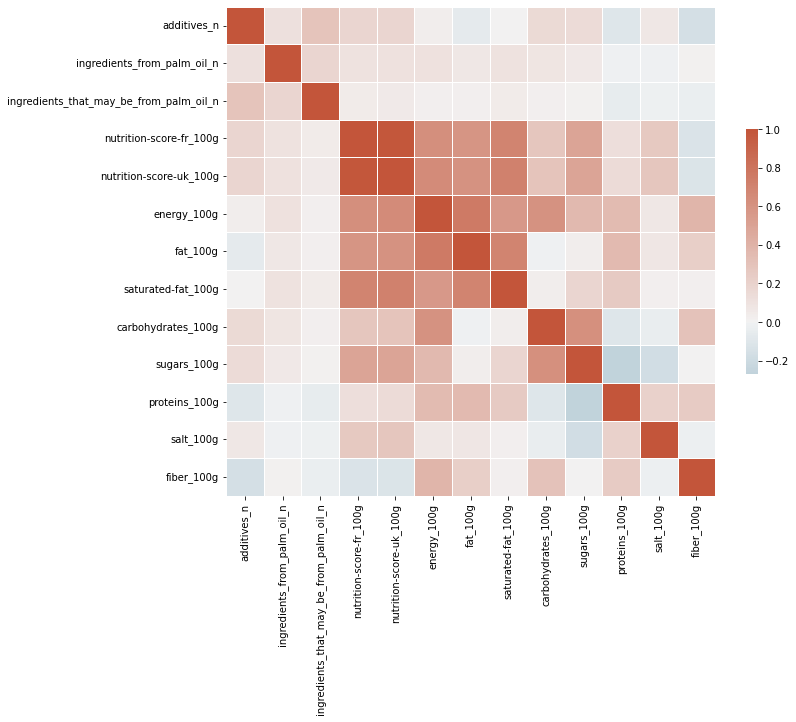

In [7]:
corr = df.loc[:, ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g']].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, center=0, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5});

#### Observations:

As in the pairplot we can see that the elements that compose the nutritional score are more correlated with it! All of them are positively correlated with the exception of the fibers that are actually negatively correlated.


#### Additives and palm oil
First I want to explore the fact that the grade 'a' has more additives which for me is intriguing. I am also surprised that the additives are not a better predictor of the score but this seems to be in agreement with the previous point since each group has as many additives (even more for group a).
<br>
Looking closely at the additives I realized that the number is not a predictive because many healthy food have actually 'good' additives in them. So I don't think that column is actually relevant in that form but after doing some research I found a list of unhealthy additives and would like to see if I can create a new column that counts the number of these unhealthy additives to see if it will be a better predictor.
<br>
So i decide to mine for 'bad' additives recorded in here https://pickyeaterblog.com/worst-food-preservatives/ and see where that leads me.

- First observation: most of them are not recorded in additives column but in the ingredient column, they are often passed in the additives or registrer as 'antioxidant' instead of 'antioxidant bha' --> fortunately I have translated the ingredient columns so I can find them without having to search in every language.
- The number of name that one additive can have is huge, I search and from my observation they are not recorded twice under different name.


<br>

In [8]:
# lets create a dict with all 0 and add the vals when the research find a bad additive
dict_bad_additives = {k: 0 for k in range(0, 186073)}

In [9]:
# lets create the loop to search for the different composants

for i, row in df[['ingredients_text_translated', 'additives']].iterrows():
    
    # sodium nitrite
    if 'sodium nitrite' in row[0] or 'sodium nitrite' in row[1]:
        dict_bad_additives[i] += 1
    
    # bha/bht/butylated hydroxyanisole
    if 'bha' in row[0] or 'bha' in row[1]:
        dict_bad_additives[i] += 1
    else:
        if 'butylated hydroxyanisole' in row[0] or 'butylated hydroxyanisole' in row[1]:
            dict_bad_additives[i] += 1
    if 'bht' in row[0] or 'bht' in row[1]:
        dict_bad_additives[i] += 1
    
    # potassium bromate/potassium salt
    if 'potassium bromate' in row[0] or 'potassium bromate' in row[1]:
        dict_bad_additives[i] += 1
    if 'potassium salt' in row[0] or 'potassium salt' in row[1]:
        dict_bad_additives[i] += 1
    
    # High Fructose Corn Syrup (7359)/ glucose syrup (6080)/corn sugar (92)/fruit fructose (1)/ iso glucose ()
    if 'high fructose corn syrup' in row[0] or 'high fructose corn syrup' in row[1]:
        dict_bad_additives[i] += 1
    if 'glucose syrup' in row[0] or 'glucose syrup' in row[1]:
        dict_bad_additives[i] += 1
    if 'corn sugar' in row[0] or 'corn sugar' in row[1]:
        dict_bad_additives[i] += 1
    if 'fruit fructose' in row[0] or 'fruit fructose' in row[1]:
        dict_bad_additives[i] += 1
    
    # trans fat (52)/ hydrogenated vegetable oil (1692)/ shortening (5676)/ partially hydrogenated ... oil (5102)
    if 'trans fat' in row[0] or 'trans fat' in row[1]:
        dict_bad_additives[i] += 1
    if 'hydrogenated vegetable oil' in row[0] or 'hydrogenated vegetable oil' in row[1]:
        dict_bad_additives[i] += 1
    if 'shortening' in row[0] or 'shortening' in row[1]:
        dict_bad_additives[i] += 1
    if 'partially hydrogenated' in row[0] or 'partially hydrogenated' in row[1]:
        dict_bad_additives[i] += 1
        
    # blue 1 (446)/ blue 2 (255)/ e133 (3709)/ green 3 (1)/ red 3 (59)/ red 40(3610)/ yellow 6 (2311)/ e110 ()/ yellow tartrazine ()/ e102 ()
    if 'blue 1' in row[0] or 'blue 1' in row[1]:
        dict_bad_additives[i] += 1
    if 'blue 2' in row[0] or 'blue 2' in row[1]:
        dict_bad_additives[i] += 1
    if 'e133' in row[0] or 'e133' in row[1]:
        dict_bad_additives[i] += 1
    if 'green 3' in row[0] or 'green 3' in row[1]:
        dict_bad_additives[i] += 1
    if 'red 3' in row[0] or 'red 3' in row[1]:
        dict_bad_additives[i] += 1
    if 'red 40' in row[0] or 'red 40' in row[1]:
        dict_bad_additives[i] += 1
    if 'yellow 6' in row[0] or 'yellow 6' in row[1]:
        dict_bad_additives[i] += 1
    if 'e110' in row[0] or 'e110' in row[1]:
        dict_bad_additives[i] += 1
    if 'yellow tartrazine' in row[0] or 'yellow tartrazine' in row[1]:
        dict_bad_additives[i] += 1
    if 'e102' in row[0] or 'e102' in row[1]:
        dict_bad_additives[i] += 1
        
    # aspartame, sucralose, splenda, sweet n low, nutrasweet
    if 'aspartame' in row[0] or 'aspartame' in row[1]:
        dict_bad_additives[i] += 1
    if 'sucralose' in row[0] or 'sucralose' in row[1]:
        dict_bad_additives[i] += 1
    if 'splenda' in row[0] or 'splenda' in row[1]:
        dict_bad_additives[i] += 1
    if 'sweet n low' in row[0] or 'sweet n low' in row[1]:
        dict_bad_additives[i] += 1
    if 'nutrasweet' in row[0] or 'nutrasweet' in row[1]:
        dict_bad_additives[i] += 1
        
    # rbgh and rbst
    if 'rbgh' in row[0] or 'rbgh' in row[1]:
        dict_bad_additives[i] += 1
    if 'rbst' in row[0] or 'rbst' in row[1]:
        dict_bad_additives[i] += 1
        
# Most of them are in the ingredients (bha has one row where they fail to report bha in the ingredient but put in the additives #31123), (bht not in ingr but in add #184382)
# that show that in nitrite and bha case these are not written in the additives!!!

## food preservatives:
# sodium nitrite (4240) --> relevant as hell
# bha/bht/butylated hydroxyanisole --> yep
# potassium bromate/potassium salt --> 
# High Fructose Corn Syrup (7359)/ glucose syrup (6080)/corn sugar (92)/fruit fructose (1)/ iso glucose ()
# trans fat (52)/ hydrogenated vegetable oil (1692)/ shortening (5676)/ partially hydrogenated ... oil (5102)

## Artificial Food Coloring / Food Dyes --> blue 1 and 2 (3)/ blue 1 (446)/ blue 2 (255)/ e133 (3709)/ green 3 (1)/ red 3 (59)/ 
# red 40(3610)/ yellow 6 (2311)/ e110 ()/ yellow tartrazine ()/ e102 ()


In [10]:
df['bad_additives'] = pd.Series(dict_bad_additives)

In [11]:
df['bad_additives'].value_counts()

0     152808
1      23478
2       4665
3       2278
4       1211
6        576
5        513
7        406
8         97
9         28
10         8
11         3
12         2
Name: bad_additives, dtype: int64

In [12]:
# The ingredients from palm oil could be feature engineered maybe ? 

df['palm_oil'] = df['ingredients_from_palm_oil_n'] + df['ingredients_that_may_be_from_palm_oil_n']

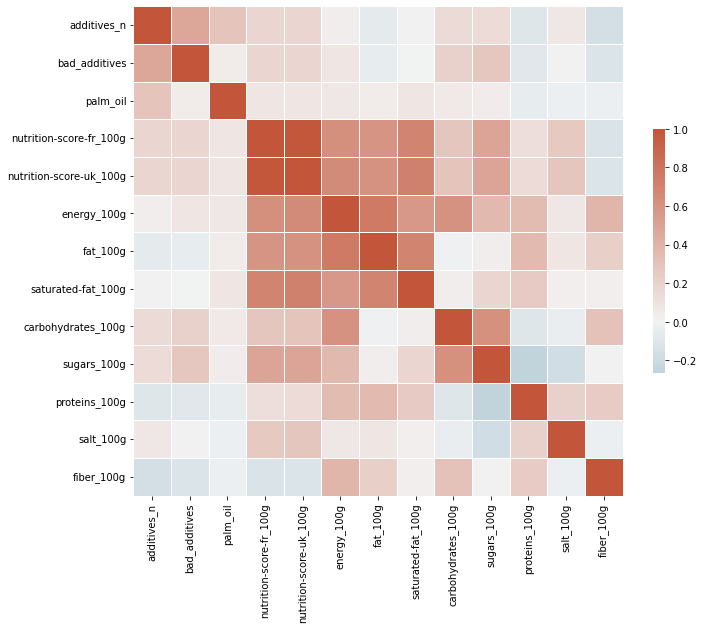

In [13]:
# nop --> what if i had them up all 

corr = df.loc[:, ['additives_n', 'bad_additives', 'palm_oil', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
                 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g']].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmax=1, center=0, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5});

The 'bad' additives doesn't seem correlated to the nutrition score but I still hope it will influence prediction on the nutrition grade.


In [14]:
# Are there grade 'a' food that have bad additives? 
pd.set_option('display.max_rows', None)
df.loc[((df['nutrition_grade_fr'] == 'a') & (df['bad_additives'] >= 1)), ['product_name', 'nutrition_grade_fr', 'bad_additives', 'ingredients_text_translated']].head(20)

# Some products are labelled "A" but seems shady, gums or jogurt with lots of bad additives. Lets see how the nutrition score and grade is calculated 

product_name nutrition_grade_fr  \
353                                source 0% mg vanille                  a   
842       tortellini aux fines herbes farcis au fromage                  a   
1207  merlu blanc sauce citron et boulgour aux petit...                  a   
1398  postre de soja &quot;savia&quot; frutas exótic...                  a   
1736                   assortiment de bhajis et pakoras                  a   
1834  colin d'alaska à la bordelaise, surgelé (2 per...                  a   
1937                                  couscous, surgelé                  a   
2064                   petit salé aux lentilles vertes                   a   
2115  postre de soja &quot;savia&quot; fresa edulcor...                  a   
2146              porc au caramel et riz à la coriandre                  a   
2278  filet de merlu blanc, sauce citronnée et son m...                  a   
2359   parmentier au potiron et poulet grillé - surgelé                  a   
2383  farfalles à la tomate, légumes grillés et mozz...                  a   
2623                               cassoulet - pur porc                  a   
2771                      teisseire citron/citron vert                   a   
2815                                    couscous royal                   a   
2953  pizza royale, cuite sur pierre (jambon, champi...                  a   
2965            lentilles vertes aux lardons, surgelées                  a   
3112  recette d'abricot, touche de gingembre (0 % mg...                  a   
3359     p'tit souper - céréales du soir légumes variés                  a   

      bad_additives                        ingredients_text_translated  
353               1  skim milk, milk and whey proteins, modified co...  
842               1  pasta: enriched durum wheat semolina (semolina...  
1207              1  small compartment 170 g: _white hake_ 52% - wa...  
1398              1  soy beverage 83% (water, soy beans 13.7%), fru...  
1736              2  Onion bhajis 50%: onion 66.9%, chickpea flour ...  
1834              1  _Alaska pollock_ 55%, onions 12%, _cream_ fres...  
1937              1  30% cooked semolina [water, durum wheat semoli...  
2064              2  cooked green lentils (30%), water, cooked smok...  
2115              1  soy beverage 83% (water, soy beans 13.7%), str...  
2146              1  precooked basmati rice 40.6%, marinated pork m...  
2278              1  small compartment (160g) (white hake fillet 37...  
2359              1  pumpkin puree 29.4%, potato puree 19.3%, water...  
2383              1  pre-cooked farfalle 35% (water, durum _wheat_ ...  
2623              1  cooked sauce: water, tomato paste, transformed...  
2771              1  water, lemon juice from concentrate 30% (lemon...  
2815              1  rehydrated durum wheat semolina 27.8% [durum w...  
2953              1  filling (55%): tomato purée 43%, cooked ham of...  
2965              1  pre-cooked green lentil 51% (water, green lent...  
3112              1  Lean yoghurt 87.5%, apricot 9.6% (apricot, apr...  
3359              1  diastase rice flour 44%, maltodextrin, vegetab...

#### How is the nutritional score/grade calculated ?

the nutritional value for the Nutri-Score letter grade is determined by subtracting the total positive points from the total negative points. And the lower the score, the better the letter grade.

It’s slightly counter-intuitive but high-quality nutrients — protein, fibre, fruits, vegetables, nuts, legumes, and olive, walnut, and rapeseed oils — earn negative points for the product (from 0 to -5, depending on the overall percentages and grams per 100 grams). 

Low-quality nutrients — energy density, sugars, saturated fatty acids, and salt — rack up positive points (from 0 to 10, again depending on grams or KJs per 100 grams).


<img src="nutriscore_calculation.jpg" width="600" height="300">

ref: https://get.apicbase.com/nutri-score-science-based-nutritional-value-labelling-system/

In [15]:
# lets try to recreate the positive and negative score with the data that we have 

df_score = df[['nutrition-score-fr_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g', 'fiber_100g', 'nutrition_grade_fr']]
# lets group them by grade and get the mean of each grade
df_score = df_score.groupby(by='nutrition_grade_fr', axis=0).agg(np.mean)
# Normalize the score for it to be easier to understand
df_score = (df_score-df_score.mean())/df_score.std()
#df_score
# create two new var to totalize the positive and negatives points
# lets not forget here that the positive point are unhealthy point and that the more a food has positive point the more unheathy
df_score['unhealthy_points'] = df_score['energy_100g'] + df_score['fat_100g'] + df_score['saturated-fat_100g'] + df_score['carbohydrates_100g'] + df_score['sugars_100g'] + df_score['salt_100g']
df_score['healthy_points'] = df_score['proteins_100g'] + df_score['fiber_100g']
df_score[['unhealthy_points', 'healthy_points']]

# I renamed the positive point the unhealthy_points because it was really confusing to have better positive points in the worst categories, I think its way clearer

unhealthy_points  healthy_points
nutrition_grade_fr                                  
a                          -5.162029        1.571642
b                          -5.808652       -2.521399
c                          -0.530528        0.382266
d                           4.245621        0.587186
e                           7.255587       -0.019695

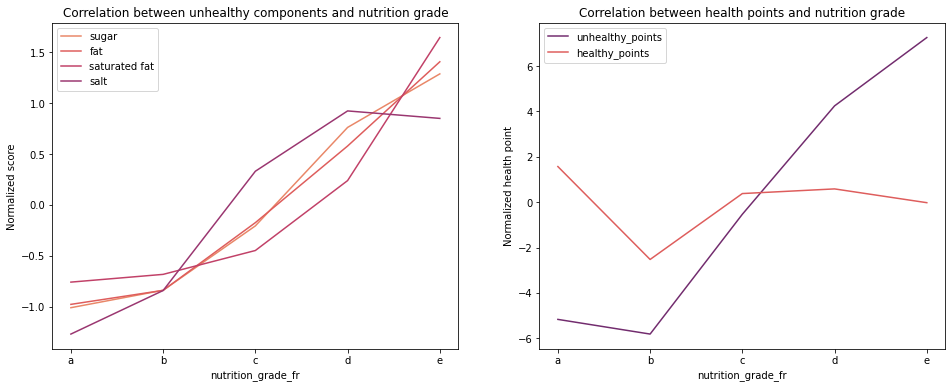

In [16]:
# with the mean we can clearly see some correlation 

fig, ([ax1, ax2]) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
palette = sns.color_palette('flare', 5)

sns.lineplot(x='nutrition_grade_fr', y='sugars_100g', data=df_score, color=palette[0], ax=ax1, label='sugar');
sns.lineplot(x='nutrition_grade_fr', y='fat_100g', data=df_score, color=palette[1], ax=ax1, label='fat');
sns.lineplot(x='nutrition_grade_fr', y='saturated-fat_100g', data=df_score, color=palette[2], ax=ax1, label='saturated fat');
sns.lineplot(x='nutrition_grade_fr', y='salt_100g', data=df_score, color=palette[3], ax=ax1, label='salt');

ax1.set_ylabel('Normalized score')
ax1.set_title('Correlation between unhealthy components and nutrition grade')

sns.lineplot(x='nutrition_grade_fr', y='unhealthy_points', data=df_score, color=palette[4], ax=ax2, label='unhealthy_points');
sns.lineplot(x='nutrition_grade_fr', y='healthy_points', data=df_score, color=palette[1], ax=ax2, label='healthy_points');
ax2.set_ylabel('Normalized health point')
ax2.set_title('Correlation between health points and nutrition grade')

plt.show();


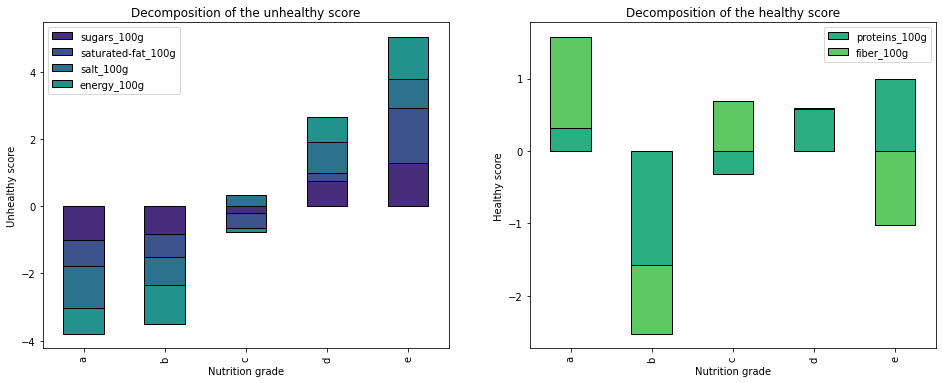

In [17]:
# lets plot to see all of that 
palette = sns.color_palette('viridis', 7)

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#plot the composition of positive points 
ax1 = df_score[['sugars_100g' ,'saturated-fat_100g', 'salt_100g', "energy_100g"]
                 ].plot(kind="bar", stacked=True, color=palette[:4], edgecolor='black', ax=ax1)

ax1.set_title('Decomposition of the unhealthy score')
ax1.set_ylabel('Unhealthy score')
ax1.set_xlabel('Nutrition grade')

# plot the composition of positive points 
ax2 = df_score[['proteins_100g' ,"fiber_100g"]
                 ].plot(kind="bar", stacked=True, color=palette[4:6], edgecolor='black', ax=ax2)

ax2.set_title('Decomposition of the healthy score')
ax2.set_ylabel('Healthy score')
ax2.set_xlabel('Nutrition grade')

plt.show();

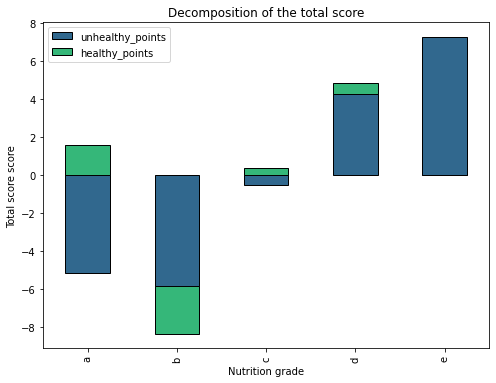

In [18]:
# We can finally plot the total score

palette = sns.color_palette('viridis', 2)

df_score[['unhealthy_points', 'healthy_points']
                 ].plot(kind="bar", stacked=True, color=palette, figsize=(8, 6), edgecolor='black')

plt.title('Decomposition of the total score')
plt.ylabel('Total score score')
plt.xlabel('Nutrition grade')

plt.show()


In [19]:
del df_score
del df_plot
del dict_bad_additives

### 2.2-3 Classification to predict the nutrition grade (a, b, c, d, e) & Regression to predict the score (-15 to 40)

In [20]:
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix

In [21]:
# choose var and separate
y = df['nutrition_grade_fr'].values
X = df.loc[:, ['additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
               'fiber_100g', 'proteins_100g', 'salt_100g', 'bad_additives', 'palm_oil']].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


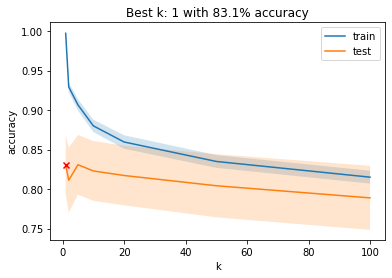

Test accuracy random forest model: 99.62%


In [22]:
# Create a k-NN pipeline

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
grid = {
    'knn__n_neighbors':[1, 2, 5, 10, 20, 50, 100],
        }
grid_knn = GridSearchCV(knn_pipe, grid, cv=5, return_train_score=True, verbose=2, n_jobs=-1)

# Fit estimator
grid_knn.fit(X, y)

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_knn.cv_results_)
# Group results by alpha value
grouped = cv_results.groupby('param_knn__n_neighbors').mean()
# Plot mean scores
plt.plot(grouped.index, grouped.mean_train_score, label='train')
plt.plot(grouped.index, grouped.mean_test_score, label='test')
# Add marker for best score
best_k = grouped.mean_test_score.idxmax()
plt.scatter(best_k, grouped.mean_test_score.max(), marker='x', c='red', zorder=10)
# Quantify variance with ±std curves
plt.fill_between(grouped.index, grouped.mean_train_score-grouped.std_train_score, grouped.mean_train_score+grouped.std_train_score, alpha=0.2)
plt.fill_between(grouped.index, grouped.mean_test_score-grouped.std_test_score, grouped.mean_test_score+grouped.std_test_score, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*grouped.mean_test_score[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

print('Test accuracy random forest model: {:.2f}%'.format(100*grid_knn.score(X_te, y_te)))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


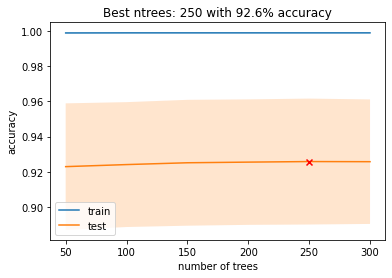

Test accuracy random forest model: 99.91%


In [23]:
# Create a RandomForest pipeline

rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_jobs=-1))
])
grid = {
    'rf__n_estimators':[50, 100, 150, 200, 250, 300],
        }
grid_rf = GridSearchCV(rf_pipe, grid, cv=5, return_train_score=True, verbose=2, n_jobs=-1)
# Fit estimator
grid_rf.fit(X, y)


# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_rf.cv_results_)
# Group results by alpha value
grouped = cv_results.groupby('param_rf__n_estimators').mean()
# Plot mean scores
plt.plot(grouped.index, grouped.mean_train_score, label='train')
plt.plot(grouped.index, grouped.mean_test_score, label='test')
# Add marker for best score
best_k = grouped.mean_test_score.idxmax()
plt.scatter(best_k, grouped.mean_test_score.max(), marker='x', c='red', zorder=10)
# Quantify variance with ±std curves
plt.fill_between(grouped.index, grouped.mean_train_score-grouped.std_train_score, grouped.mean_train_score+grouped.std_train_score, alpha=0.2)
plt.fill_between(grouped.index, grouped.mean_test_score-grouped.std_test_score, grouped.mean_test_score+grouped.std_test_score, alpha=0.2)
plt.title('Best ntrees: {} with {:.1f}% accuracy'.format(best_k, 100*grouped.mean_test_score[best_k]))
plt.ylabel('accuracy')
plt.xlabel('number of trees')
plt.legend()
plt.show()

print('Test accuracy random forest model: {:.2f}%'.format(100*grid_rf.score(X_te, y_te)))

As planned its quite easy to predict the nutritional grade as its a classification task with good correlated data. <br>
I think it's going to be more challenging on the regression one. 


#### 2.2 Regression to predict nutritional score

Lets create a simple baseline with 3 of the most correlated columns to see what it gives us. 

In [24]:
# Baseline
# lets fit a very basic one with the 3 most correlated columns
y = df['nutrition-score-fr_100g'].values
X = df.loc[:, ['energy_100g', 'saturated-fat_100g','sugars_100g']].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

lr = LinearRegression(n_jobs=-1)
lr.fit(X_tr, y_tr)
print('Linear Regression for the nutritional score with {:.1f}% accuracy'.format(100*lr.score(X_te, y_te)))

# Not bad as baseline!

Linear Regression for the nutritional score with 65.4% accuracy


I am actually surprised by the baseline score as I was expecting worst! Lets see what we can do with a better model.

Fitting 5 folds for each of 2 candidates, totalling 10 fits


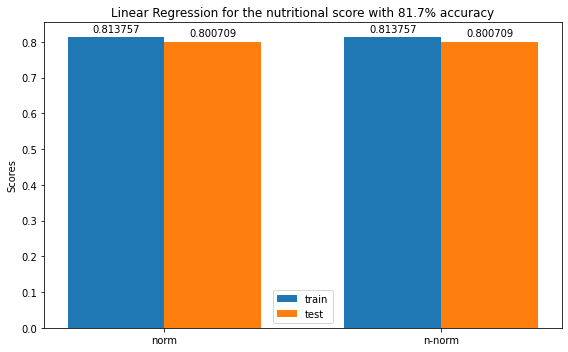

In [25]:
# lets take the other var
y = df['nutrition-score-fr_100g'].values
X = df.loc[:, ['additives_n', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
               'fiber_100g', 'proteins_100g', 'salt_100g', 'bad_additives', 'palm_oil']].values

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

# Create a logistic regression pipeline

lr_pipe = Pipeline([
    ('lr', LinearRegression(n_jobs=-1))
])
grid = {
    'lr__normalize':[True, False],
        }

grid_lr = GridSearchCV(lr_pipe, grid, cv=5, return_train_score=True, verbose=2, n_jobs=-1)
# Fit estimator
grid_lr.fit(X, y)

# Collect results in a DataFrame
cv_results = pd.DataFrame(grid_lr.cv_results_)

labels = ['train', 'test']
train = [cv_results.mean_train_score[0], cv_results.mean_train_score[1]]
test = [cv_results.mean_test_score[0], cv_results.mean_test_score[1]]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train, width, label='train')
rects2 = ax.bar(x + width/2, test, width, label='test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
plt.title('Linear Regression for the nutritional score with {:.1f}% accuracy'.format(100*grid_lr.score(X_te, y_te)))
ax.set_xticks(x, ['norm', 'n-norm'])
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
fig.tight_layout()
plt.show()

<br>

Succeeding in predicting the grade with 99% success is a great prediction especially knowing that we lack the amount of fruit and vegetables in the food! 
I think it could be relevant to develop an application that scans and indicates the score of the product according to these components even if it would require a very robust code because the quantities are not always given in 100g and it is sometimes difficult to remove the relevant information from the labels.

The prediction is more difficult at the score level without much surprise, I think it would be better with fruits and vegetables. I think it would be interesting to see also if we could have a set of models with one model predicting the negative score (proteins-fibers), another one the positive score and a third one taking the input from these two models to predict the score. 

I'll try to come back to do this later!

### 2.4 Clustering with KMeans

In [26]:
X = df.loc[:, ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
               'fiber_100g', 'proteins_100g', 'salt_100g']].values

In [27]:
# Create k-means object
kmeans = KMeans(
    n_clusters=5, # Number of grades
    random_state=0 # Fix results
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Fit it to the data
kmeans.fit(X_scaled, y=None);

# Lets add it to the df
df['clusters'] = kmeans.labels_

I am really curious to see what features the kmeans utilize to extract the centers, I am going to inverse the problem: transform it into a supervised problem ans extract the features importance.

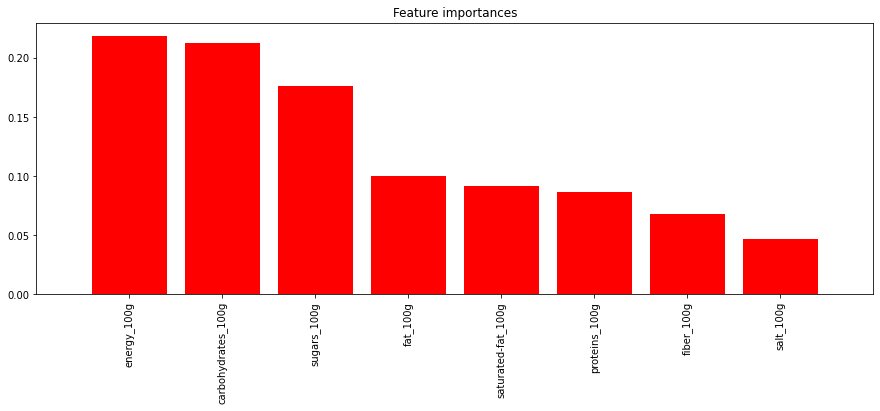

In [28]:
# retransform using cluster as target
y = df['clusters'].values
# X_scaled -- same X different y

names = df.loc[:, ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
               'fiber_100g', 'proteins_100g', 'salt_100g']].columns # to retrieve the name of the cols after

# create and fit model
clf = RandomForestClassifier(random_state=1)
clf.fit(X_scaled, y)

features = clf.feature_importances_ # extract feat importance
indices = np.argsort(features)[::-1] # and their indx
names_ind = names[indices]

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(15,5))
plt.title("Feature importances")
plt.bar(range(X_scaled.shape[1]), features[indices],color="r", align="center")
plt.xticks(range(X_scaled.shape[1]), names_ind, rotation='vertical')
plt.xlim([-1, X_scaled.shape[1]])
plt.show()

I want to see if the clusters looks like the nutritional grades, lets compare the two of them.

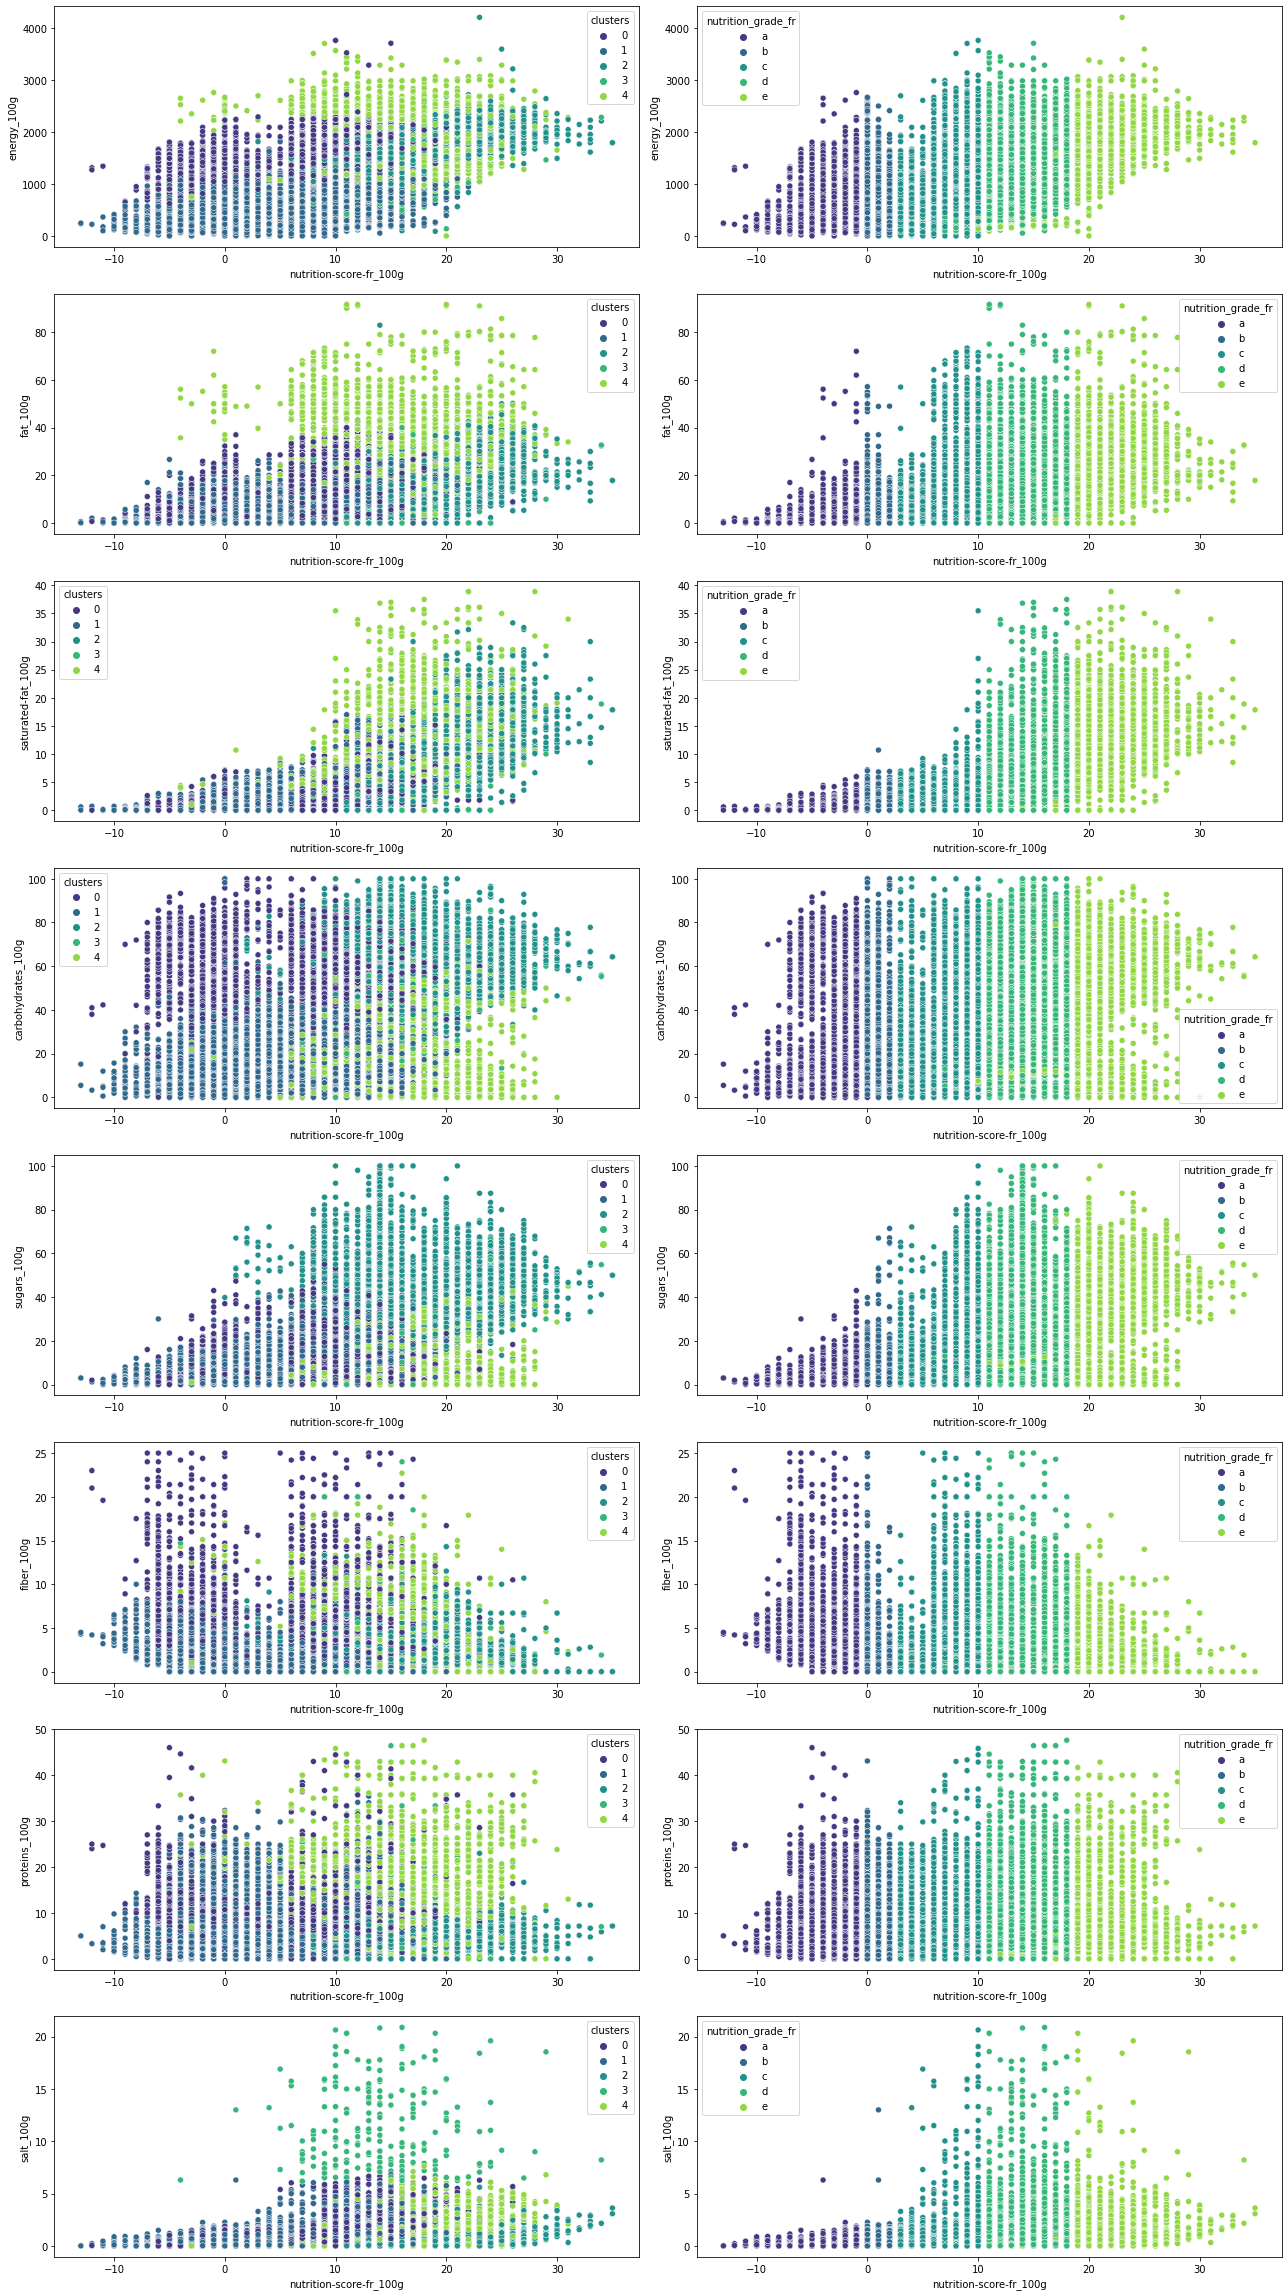

In [29]:
df_plot = df.sample(20_000)

palette = sns.color_palette('viridis', 5)

fig,axes = plt.subplots(nrows=8,ncols=2,figsize=(18,8*4))

cols = ['energy_100g', 'energy_100g', 'fat_100g','fat_100g', 'saturated-fat_100g', 'saturated-fat_100g', 
        'carbohydrates_100g', 'carbohydrates_100g', 'sugars_100g', 'sugars_100g', 
        'fiber_100g', 'fiber_100g', 'proteins_100g', 'proteins_100g', 'salt_100g', 'salt_100g']
hue = ['clusters', 'nutrition_grade_fr'] * 8

for col, ax, h in zip(cols, axes.ravel(), hue):
    if h == 'nutrition_grade_fr':
        sns.scatterplot(y=col, x='nutrition-score-fr_100g', hue=h, data=df_plot, hue_order=['a', 'b', 'c', 'd', 'e'], palette=palette, ax=ax)
    elif h == 'clusters':
        sns.scatterplot(y=col, x='nutrition-score-fr_100g', hue=h, data=df_plot, hue_order=[0, 1, 2, 3, 4], palette=palette, ax=ax)

plt.tight_layout()

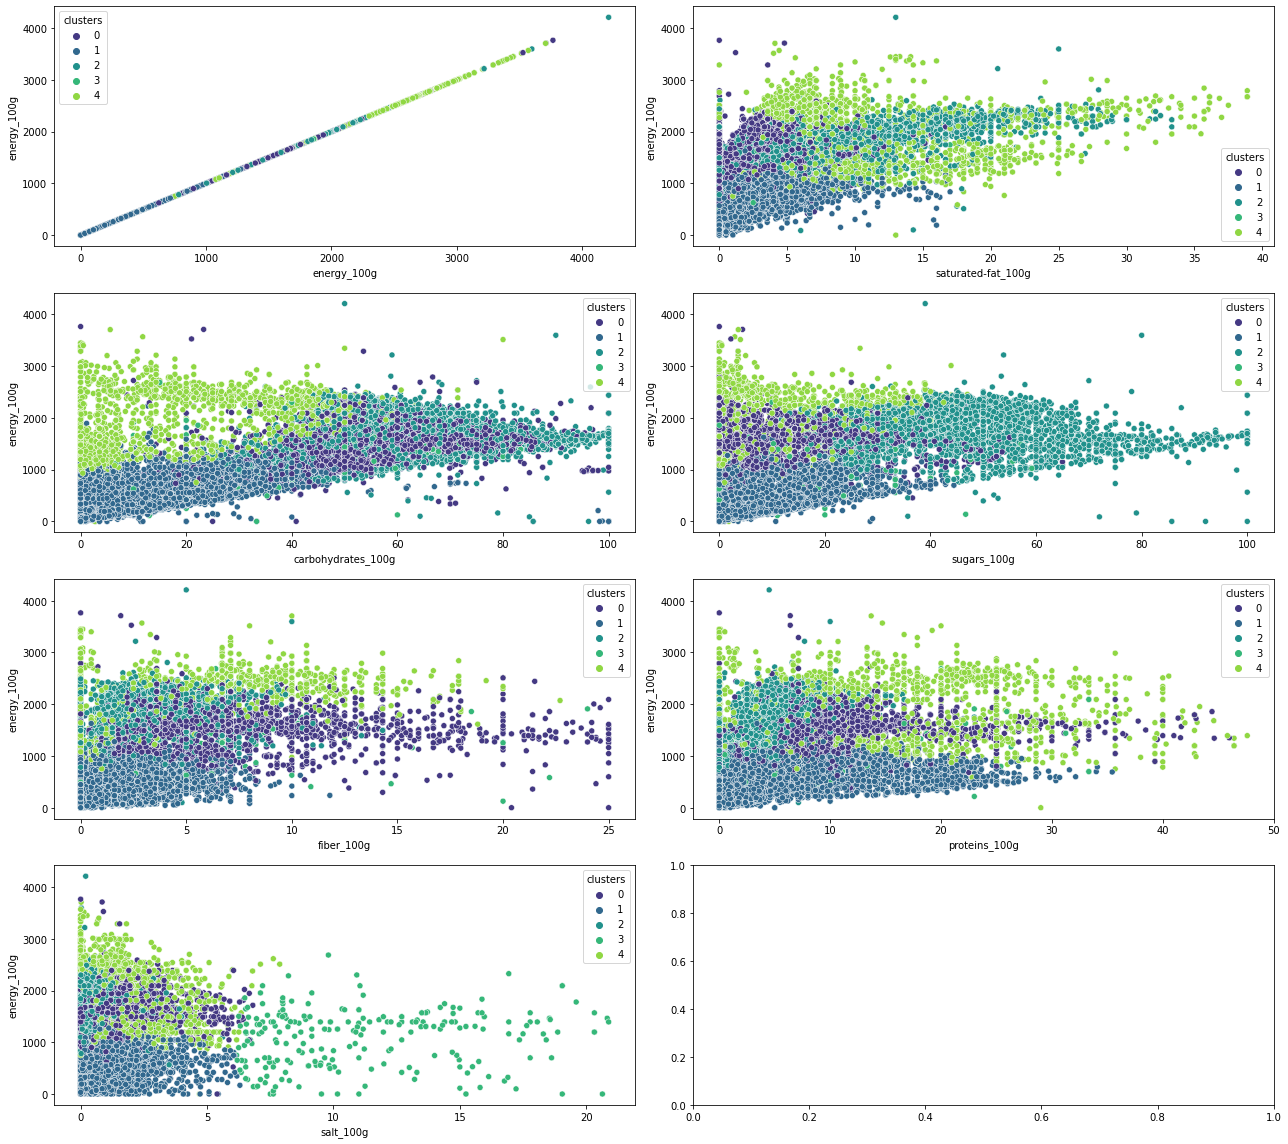

In [30]:
palette = sns.color_palette('viridis', 5)

fig,axes = plt.subplots(nrows=4,ncols=2,figsize=(18,4*4))

cols = ['energy_100g','saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

for col, ax in zip(cols, axes.ravel()):
        sns.scatterplot(x=col, y='energy_100g', data=df_plot, hue='clusters', hue_order=[0, 1, 2, 3, 4], palette=palette, ax=ax)

plt.tight_layout()

From those grpah we can indeed see that:

- energy and carbohydrates and sugar are visibly the most important feature used by the KMeans to classify our data. 
- the clusters are not alike the grades, which could be planned from the way of calculating the grades that's way more complex than a basic regression.
- even standardized energy is the biggest predictor, it was expected when non standardized because the energy values are in kJ which are way bigger than the others but I was not especially expecting energy to be the biggest predictor when scaled.